In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, advanced_activations, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


In [4]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


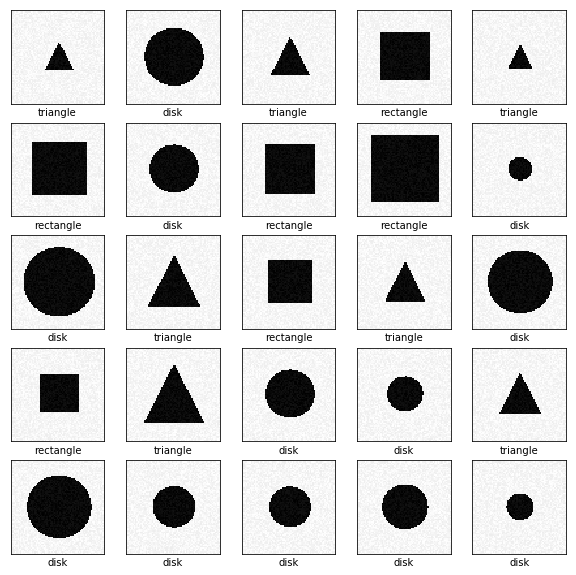

In [5]:
class_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(72,72), cmap= 'gray')
    plt.xlabel(class_names[int(Y_train[i])])

In [7]:
y_train = np_utils.to_categorical(Y_train, 3)

In [8]:
Y_train.shape, y_train.shape

((300,), (300, 3))

<font color = black> 

# 3. Simple Classification
# SGD Optimizer

In [9]:
#Sequential model 
model_sgd = Sequential()
#One hidden layer with 16 neurons and relu activation function
model_sgd.add(Dense(16, activation = 'relu'))
#3 neurons to suit the shape of y_train
model_sgd.add(Dense(3, activation = 'softmax'))

#Optimization method: Stochastic Gradient descent 
sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov=True)
model_sgd.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])

model_sgd.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 2s 9ms/step - loss: 0.2422 - acc: 0.4667 - val_loss: 0.2011 - val_acc: 0.5333
Epoch 2/20
240/240 [==============================] - 0s 287us/step - loss: 0.2064 - acc: 0.5250 - val_loss: 0.1911 - val_acc: 0.5500
Epoch 3/20
240/240 [==============================] - 0s 258us/step - loss: 0.1899 - acc: 0.5583 - val_loss: 0.1626 - val_acc: 0.7000
Epoch 4/20
240/240 [==============================] - 0s 254us/step - loss: 0.1664 - acc: 0.6500 - val_loss: 0.1722 - val_acc: 0.6167
Epoch 5/20
240/240 [==============================] - 0s 237us/step - loss: 0.1536 - acc: 0.7125 - val_loss: 0.1451 - val_acc: 0.7167
Epoch 6/20
240/240 [==============================] - 0s 275us/step - loss: 0.1381 - acc: 0.7667 - val_loss: 0.1396 - val_acc: 0.7167
Epoch 7/20
240/240 [==============================] - 0s 254us/step - loss: 0.1250 - acc: 0.7917 - val_loss: 0.1217 - val_acc: 0.8167
Epoch 8/20
240/240 

In [10]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0]) 
model_sgd.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

The triangle is predicted correctly.

<font color = black> 
    
# Adam Optimizer

In [14]:
#Same architecture with Adam Optimizer
model_adam = Sequential()
model_adam.add(Dense(16, activation = 'relu'))
model_adam.add(Dense(3, activation = 'softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model_adam.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 2ms/step - loss: 1.6753 - acc: 0.3042 - val_loss: 1.4234 - val_acc: 0.3000
Epoch 2/20
240/240 [==============================] - 0s 325us/step - loss: 1.1984 - acc: 0.4625 - val_loss: 0.9636 - val_acc: 0.4000
Epoch 3/20
240/240 [==============================] - 0s 316us/step - loss: 0.9537 - acc: 0.4375 - val_loss: 0.9600 - val_acc: 0.6000
Epoch 4/20
240/240 [==============================] - 0s 271us/step - loss: 0.7819 - acc: 0.6500 - val_loss: 0.6888 - val_acc: 0.7500
Epoch 5/20
240/240 [==============================] - 0s 316us/step - loss: 0.6362 - acc: 0.7625 - val_loss: 0.6273 - val_acc: 0.8833
Epoch 6/20
240/240 [==============================] - 0s 329us/step - loss: 0.5967 - acc: 0.7875 - val_loss: 0.6907 - val_acc: 0.7167
Epoch 7/20
240/240 [==============================] - 0s 275us/step - loss: 0.6461 - acc: 0.6833 - val_loss: 0.5684 - val_acc: 0.7333
Epoch 8/20
240/240 

In [15]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0]) 
model_adam.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

The rectangle is predicted correctly.

<font color = black> 
    
# 4. Visualization of the Solution

In [16]:
model_sgd.get_weights()[0].shape

(5184, 16)

In [17]:
#Matrix multiplication to get the global weight of the classifier for SGD and ADAM 
weights_sgd = model_sgd.get_weights()[0] @ model_sgd.get_weights()[2]
weights_adam = model_adam.get_weights()[0] @ model_adam.get_weights()[2]

Text(0.5,1,'Sgd Classifier for triangle')

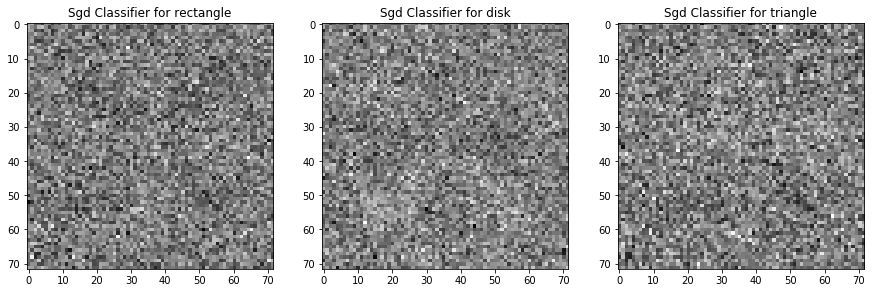

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(weights_sgd[:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[0].set_title('Sgd Classifier for rectangle')

axes[1].imshow(weights_sgd[:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[1].set_title('Sgd Classifier for disk')

axes[2].imshow(weights_sgd[:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[2].set_title('Sgd Classifier for triangle')

Text(0.5,1,'Adam Classifier for triangle')

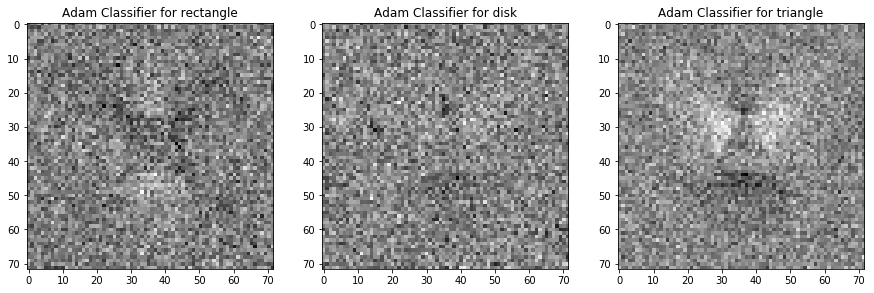

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(weights_adam[:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[0].set_title('Adam Classifier for rectangle')

axes[1].imshow(weights_adam[:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[1].set_title('Adam Classifier for disk')

axes[2].imshow(weights_adam[:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[2].set_title('Adam Classifier for triangle')

<font color = black> 
    
# 5. A More Diﬃcult Classiﬁcation Problem

In [20]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [21]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [22]:
y_train = np_utils.to_categorical(Y_train, 3)

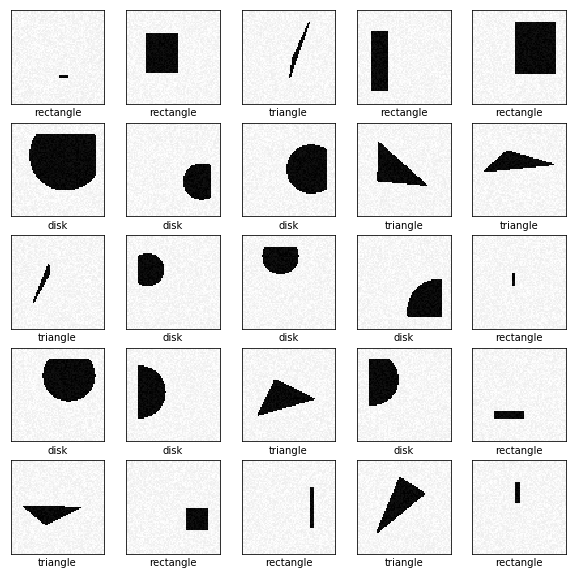

In [23]:
class_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(72,72), cmap= 'gray')
    plt.xlabel(class_names[int(Y_train[i])])

In [24]:
model_test = Sequential()
model_test.add(Dense(16, activation = 'relu'))
model_test.add(Dense(3, activation = 'softmax'))

sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov=True)
model_test.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])

model_test.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 2ms/step - loss: 0.2294 - acc: 0.4125 - val_loss: 0.2309 - val_acc: 0.3333
Epoch 2/20
240/240 [==============================] - 0s 279us/step - loss: 0.2285 - acc: 0.3875 - val_loss: 0.2061 - val_acc: 0.5167
Epoch 3/20
240/240 [==============================] - 0s 242us/step - loss: 0.2192 - acc: 0.4167 - val_loss: 0.2071 - val_acc: 0.5500
Epoch 4/20
240/240 [==============================] - 0s 279us/step - loss: 0.2170 - acc: 0.4750 - val_loss: 0.2077 - val_acc: 0.4667
Epoch 5/20
240/240 [==============================] - 0s 279us/step - loss: 0.2109 - acc: 0.5167 - val_loss: 0.2124 - val_acc: 0.3833
Epoch 6/20
240/240 [==============================] - 0s 254us/step - loss: 0.2105 - acc: 0.5167 - val_loss: 0.2227 - val_acc: 0.3167
Epoch 7/20
240/240 [==============================] - 0s 279us/step - loss: 0.2072 - acc: 0.5208 - val_loss: 0.2037 - val_acc: 0.5000
Epoch 8/20
240/240 

The linear classifier performs poorly when we allow shapes to move and to change size.
We have to add more layers to classify well.

In [25]:
score = model_test.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

300/300 [==============================] - 0s 133us/step
Test loss: 0.21523606538772583
Test accuracy: 0.44666666666666666


In [26]:
#Necessary to reshape our data to use a convolution layer
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

In [27]:
model_conv = Sequential()

#Convolution with 32 features map and a covolution matrix 5X5
model_conv.add(Conv2D(32, (5, 5), activation = 'relu', input_shape = (72, 72, 1)))
print(model_conv.output_shape)

#Pooling: divide the size by 2
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
print(model_conv.output_shape)

#Add Flatten in order to add fully connected layer
model_conv.add(Flatten())
print(model_conv.output_shape)

#Fully connected layer to suit the output shape
model_conv.add(Dense(3, activation = 'softmax'))
print(model_conv.output_shape)

model_conv.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_conv.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

(None, 68, 68, 32)
(None, 34, 34, 32)
(None, 36992)
(None, 3)
Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 3s 13ms/step - loss: 2.5158 - acc: 0.3833 - val_loss: 2.2363 - val_acc: 0.3000
Epoch 2/20
240/240 [==============================] - 2s 8ms/step - loss: 1.2477 - acc: 0.4333 - val_loss: 0.9837 - val_acc: 0.4500
Epoch 3/20
240/240 [==============================] - 2s 8ms/step - loss: 0.9259 - acc: 0.5542 - val_loss: 0.9222 - val_acc: 0.5667
Epoch 4/20
240/240 [==============================] - 2s 8ms/step - loss: 0.8033 - acc: 0.7500 - val_loss: 0.8736 - val_acc: 0.6833
Epoch 5/20
240/240 [==============================] - 2s 8ms/step - loss: 0.7287 - acc: 0.8417 - val_loss: 0.9048 - val_acc: 0.6333
Epoch 6/20
240/240 [==============================] - 2s 8ms/step - loss: 0.6458 - acc: 0.8417 - val_loss: 0.8240 - val_acc: 0.7000
Epoch 7/20
240/240 [==============================] - 2s 8ms/step - loss: 0.5666 - acc: 0.8708 - val

In [28]:
score = model_conv.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

300/300 [==============================] - 1s 3ms/step
Test loss: 0.7467541098594666
Test accuracy: 0.68


Drop in accuracy beween train and test set.

In [29]:
y_conv_pred = model_conv.predict(X_test)

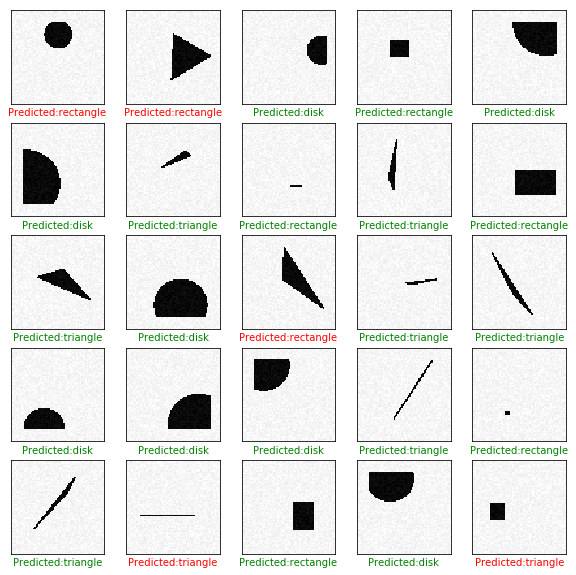

In [30]:
class_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i].reshape(72,72), cmap= 'gray')
    if np.argmax(y_conv_pred[i]) == np.argmax(Y_test[i]):
        plt.xlabel('Predicted:' + class_names[np.argmax(y_conv_pred[i])], color = 'green')
    else:
        plt.xlabel('Predicted:' + class_names[np.argmax(y_conv_pred[i])], color = 'red')
         

<font color = black> 
    
# 6. A Regression Problem

In [31]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


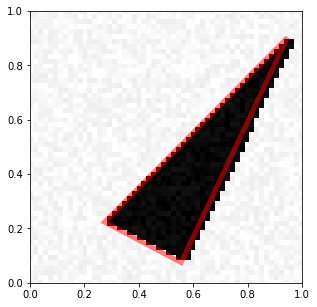

In [32]:
visualize_prediction(X_train[0], Y_train[0])

In [33]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [34]:
#Normalizer to read the vertices in ascending order for y
def normalizer(array):
    nb_samples = array.shape[0]
    normalized_array = np.copy(array)
    
    for k in range(nb_samples):
        x1, y1, x2, y2, x3, y3 = array[k, 0], array[k, 1], array[k, 2], array[k, 3], array[k, 4], array[k, 5]
        couple = {y1:x1, y2:x2, y3:x3}
        couple_list = list(couple)
        couple_list.sort()
        normalized = []
        
        for key in couple_list:
            normalized.append(couple[key])
            normalized.append(key)
        
        normalized_array[k] = normalized
    
    return(normalized_array)

In [35]:
Y_train_norm = normalizer(Y_train)
Y_test_norm = normalizer(Y_test)

In [36]:
#Concolution layer so necessary to reshape the datasets
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

In [37]:
model_regression = Sequential()

#3 Convolution layers in order to increase progressively the information we retrieved
model_regression.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten to suit fully connected layers
model_regression.add(Flatten())

model_regression.add(Dense(128, activation = 'relu'))

#Activation linear to suit the linear problem
model_regression.add(Dense(6, activation = 'linear'))

#Regression model so the metric is MSE
model_regression.compile(loss = 'mean_squared_error', optimizer = 'adam')

model_regression.fit(X_train, Y_train_norm, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 5s 20ms/step - loss: 0.1468 - val_loss: 0.1057
Epoch 2/20
240/240 [==============================] - 4s 16ms/step - loss: 0.0770 - val_loss: 0.0635
Epoch 3/20
240/240 [==============================] - 4s 16ms/step - loss: 0.0597 - val_loss: 0.0483
Epoch 4/20
240/240 [==============================] - 4s 16ms/step - loss: 0.0431 - val_loss: 0.0363
Epoch 5/20
240/240 [==============================] - 4s 17ms/step - loss: 0.0338 - val_loss: 0.0307
Epoch 6/20
240/240 [==============================] - 4s 17ms/step - loss: 0.0292 - val_loss: 0.0279
Epoch 7/20
240/240 [==============================] - 4s 16ms/step - loss: 0.0263 - val_loss: 0.0239
Epoch 8/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0224 - val_loss: 0.0218
Epoch 9/20
240/240 [==============================] - 4s 19ms/step - loss: 0.0184 - val_loss: 0.0219
Epoch 10/20
240/240 [=========================

In [38]:
model_regression.evaluate(X_test, Y_test_norm)

300/300 [==============================] - 2s 5ms/step


0.015624311864376067

Loss on test set more than 5 times bigger than on the train test.

In [39]:
y_pred = model_regression.predict(X_test)

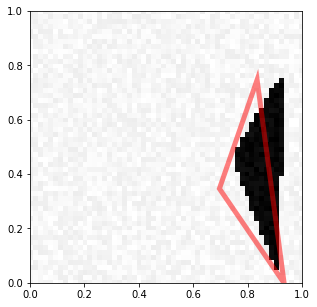

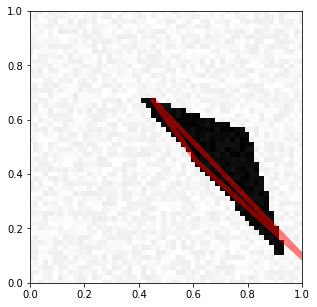

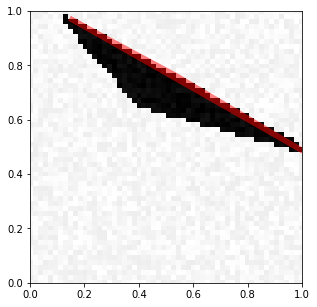

In [40]:
visualize_prediction(X_test[4], y_pred[4])
visualize_prediction(X_test[5], y_pred[5])
visualize_prediction(X_test[6], y_pred[6])

Performance are quite disappointing. 
It may have been better by adding more CVN Layers and bigger Fully connected Layers.

<font color = black> 
    
# 7. Image Denoising

In [41]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_bis(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing_bis(figsize, U, V, noise), generate_a_drawing_bis(figsize, U, V, 0)]


def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing_bis(figsize, U, V, noise), generate_a_drawing_bis(figsize, U, V, 0)]

def generate_a_triangle_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return [generate_a_drawing_bis(figsize, U, V, noise), generate_a_drawing_bis(figsize, U, V, 0)] 
    


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification_bis(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_bis()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    #print('Creating data:')
    for i in range(nb_samples):
        #Random noise added
        noise = np.random.randint(255)
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle_bis(noise, free_location)
            
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk_bis(noise, free_location)
            
        else:
            [X[i], Y[i]] = generate_a_triangle_bis(noise, free_location)
            
        X[i] = (X[i] + noise) / (255 + 2 * noise)
        Y[i] = Y[i] / 255
    return [X, Y]

def generate_test_set_classification_bis():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification_bis(300, free_location=True)
    return [X_test, Y_test]


In [42]:
[X_noised_train, Y_denoised_train] = generate_dataset_classification_bis(600, free_location = True)

In [43]:
[X_noised_test, Y_denoised_test] = generate_test_set_classification_bis()

In [44]:
X_noised_train = X_noised_train.reshape(X_noised_train.shape[0], 72, 72, 1) 
Y_denoised_train = Y_denoised_train.reshape(Y_denoised_train.shape[0], 72, 72, 1) 
X_noised_test = X_noised_test.reshape(X_noised_test.shape[0], 72, 72, 1)
Y_denoised_test = Y_denoised_test.reshape(Y_denoised_test.shape[0], 72, 72, 1)

Text(0.5,1,'Denoised image')

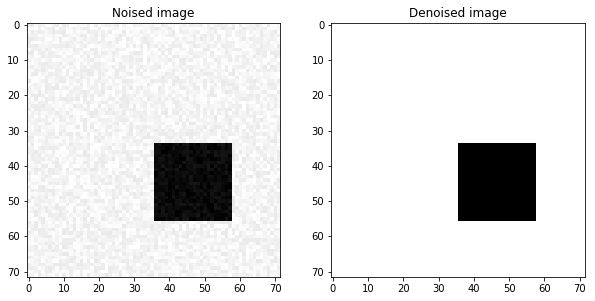

In [46]:
f, axes = plt.subplots(1, 2, figsize=(10,10))

axes[0].imshow(X_noised_train[0].reshape(72,72), cmap= 'gray')
axes[0].set_title('Noised image')

axes[1].imshow(Y_denoised_train[0].reshape(72,72), cmap= 'gray')
axes[1].set_title('Denoised image')

In [47]:
model_denoise = Sequential()

#Succession of CVN Layers with one with 1 feature map to finish
model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear',input_shape=(72,72,1), padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(MaxPooling2D(pool_size=(2, 2)))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(64, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(MaxPooling2D(pool_size=(2, 2)))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(UpSampling2D(size=(2, 2)))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(UpSampling2D(size=(2, 2)))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same'))
print(model_denoise.output_shape)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_denoise.compile(loss='mean_squared_error', optimizer = adam ,metrics=['accuracy'])

model_denoise.fit(X_noised_train, Y_denoised_train, epochs= 10, batch_size = 20, validation_split = 0.2)

(None, 72, 72, 32)
(None, 36, 36, 32)
(None, 36, 36, 64)
(None, 18, 18, 64)
(None, 18, 18, 32)
(None, 36, 36, 32)
(None, 72, 72, 32)
(None, 72, 72, 1)
Train on 480 samples, validate on 120 samples
Epoch 1/10
480/480 [==============================] - 25s 53ms/step - loss: 0.0994 - acc: 0.9070 - val_loss: 0.0879 - val_acc: 0.9067
Epoch 2/10
480/480 [==============================] - 24s 51ms/step - loss: 0.0588 - acc: 0.9255 - val_loss: 0.0253 - val_acc: 0.9852
Epoch 3/10
480/480 [==============================] - 24s 51ms/step - loss: 0.0149 - acc: 0.9824 - val_loss: 0.0105 - val_acc: 0.9859
Epoch 4/10
480/480 [==============================] - 24s 50ms/step - loss: 0.0079 - acc: 0.9895 - val_loss: 0.0063 - val_acc: 0.9923
Epoch 5/10
480/480 [==============================] - 24s 50ms/step - loss: 0.0058 - acc: 0.9928 - val_loss: 0.0062 - val_acc: 0.9920
Epoch 6/10
480/480 [==============================] - 24s 50ms/step - loss: 0.0054 - acc: 0.9932 - val_loss: 0.0055 - val_acc: 0.9929

In [48]:
Y_pred_denoised = model_denoise.predict(X_noised_test)

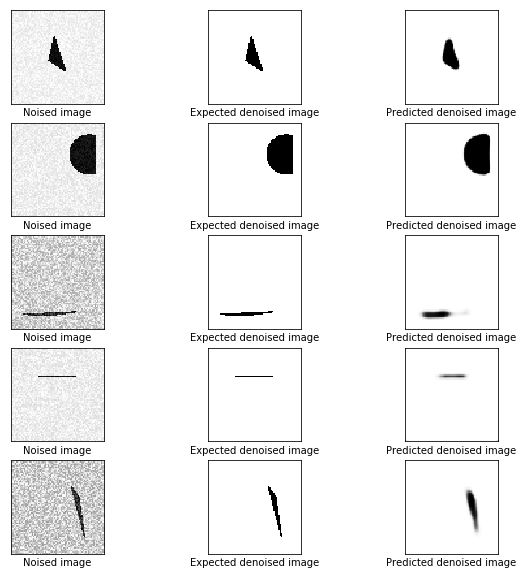

In [49]:
plt.figure(figsize=(10,10))
c = 5
for i in range(5):
    for k in range(1,4):
        plt.subplot(5,3,3*i+k)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if k ==1:
            plt.imshow(X_noised_test[50+i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Noised image')
        elif k ==2:
            plt.imshow(Y_denoised_test[50+i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Expected denoised image')
        elif k ==3:
            plt.imshow(Y_pred_denoised[50+i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Predicted denoised image')

The denoising modifies and blur slighly the shapes. 